# Multi-dimensional deconvolution - step-by-step guide

### Author: M.Ravasi

Many processing step in the seismic processing chain lend naturally to the creation and solution of large scale systems of equations. 

One of the most common building blocks of wave-equation-based processing of seismic data is the so-called multi-dimensional convolution (MDC) operator. Such an operator underlies some of the most common algorithms such SRME, IME and interferometry by multi-dimensional deconvolution (MDD) and Marchenko-based redatuming. 

In this notebook I will show you how to use the **MDC** linear operator of *Pylops* and its usage in the problem of **Multi-dimensional deconvolution (MDD)**.

In [1]:

!pip install pylops

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/MDD-StochasticSolvers/')

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ d(s,v,f) = \int_S R(s,r,f) m(v,r,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{G}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [22]:
#x= np.array([0, 1, 2, 3, 4])
#print(x)

# regular
#y = x[::2]
#print(y)

# irregular
#iava=[0,3,4]   # HARD CODED -> N elements, Nsub elements : iava
#x[iava]

In [45]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap


G.shape

(101, 61, 400)

In [46]:
#sampling function

def subsample(Gwav1,factor,stype):
  if stype == 'r':
     Gwav1 = Gwav1[::factor,::,::]
  elif stype == 'ir': 
     Gwav1 = Gwav1[np.sort(np.random.choice(Gwav1.shape[0], factor*10, replace = False)),:,:]
  else:
     print(" Sampling is not done. Choose r or ir sampling type.")
  return Gwav1


In [47]:
#calling the function

Gwav = subsample(Gwavoriginal,5,"ir")
Gwav.shape

(50, 61, 400)

In [48]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

m.shape

(799, 61)

In [49]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)

Dot test passed, v^T(Opu)=4354.656926-1585.601454i - u^T(Op^Tv)=4354.656926-4346.518873i


In [50]:
# defining the gradient

def evaluate_gradient(Gwav, d,minv,nfmax,lm, type = float):
  Gwav_fft = np.fft.rfft(Gwav, 2*nt-1, axis=-1)
  Gwav_fft = Gwav_fft[...,:nfmax]
  MDCop1 = MDC(Gwav_fft.transpose(2,0,1),nt = 2*nt-1, nv=1, dt=dt, dr=dr, twosided = True,transpose = False)
 
  
  data1=MDCop1*minv.flatten()
  data1= data1.reshape(2*nt-1, ns)

  res = d - data1
  cost= np.sum(np.power((res),2))

  grad = (-2*MDCop1.H*res.flatten()) + 2*lm*minv.flatten()
  grad = grad.reshape(2*nt-1,nr)

  return grad, cost, res


In [53]:

# Assigning the gradient

lr =0.000001
lm = 0.001
n_epochs = 1000
nfmax = 200
c=[]
minv = np.zeros((m.shape[0], m.shape[1]))

for i in range(n_epochs):
  grad, cost, res = evaluate_gradient(Gwav2, d, minv, nfmax = nfmax, lm=lm)
  c.append(cost)
  # cost = np.asarray(c)
  minv = minv.flatten() - (lr * grad.flatten())
  minv = minv.reshape(2*nt-1,nr)

  
   


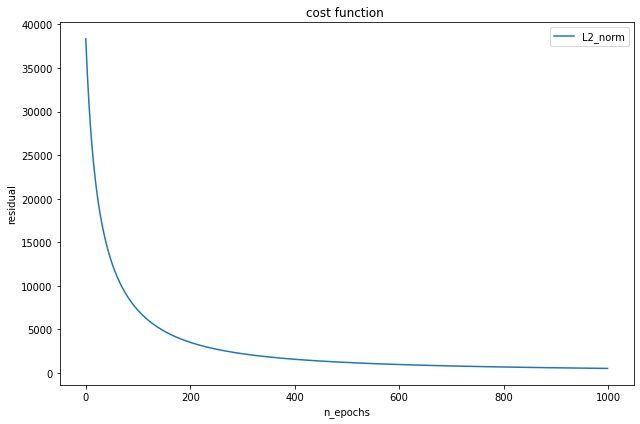

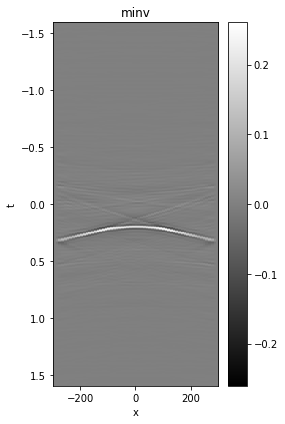

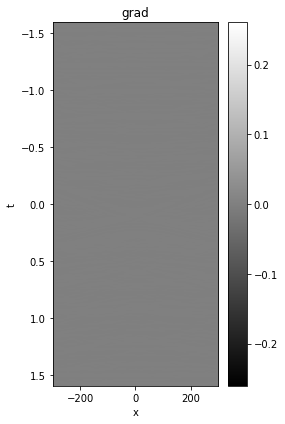

In [54]:
fig = plt.figure(figsize= (9,6))
plt.plot(c, label = 'L2_norm')
plt.title('cost function ', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()


fig = plt.figure(figsize= (4,6))
plt.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.colorbar()
plt.title('minv', fontsize=12)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize= (4,6))
plt.imshow(grad*lr, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.colorbar()
plt.title('grad', fontsize=12)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

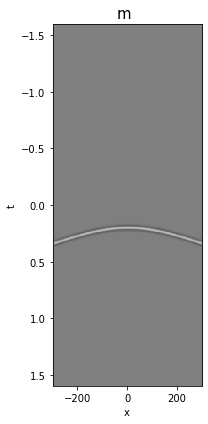

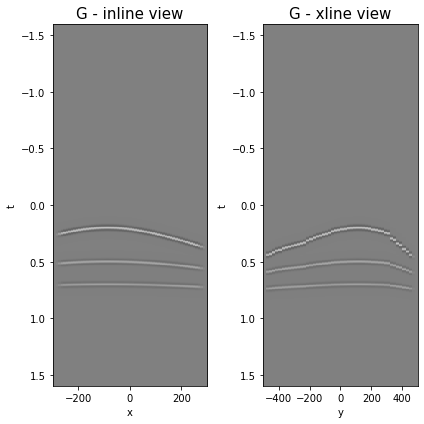

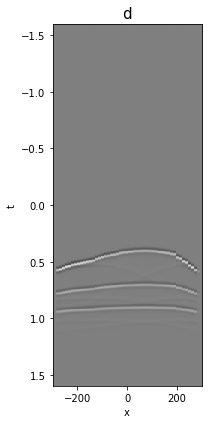

In [14]:

# Plotting
plt.figure(figsize=(3, 6))
plt.imshow(mwav,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(Gwav2[int(ns/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(nr/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(3, 6))
plt.imshow(d, aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## Application 1: Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

### Single virtual source

Let's take from where we left and invert our MDC operator. This is done directly using the LSQR solver

In [15]:
madj = MDCop.H*d.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.ravel(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*nt-1, nr)
minv = minv.reshape(2*nt-1, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    39950 rows  and    48739 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.980e+02  1.980e+02    1.0e+00  5.0e-01
     1  0.00000e+00   1.292e+02  1.292e+02    6.5e-01  6.3e-01   1.3e+02  1.0e+00
     2  0.00000e+00   9.294e+01  9.294e+01    4.7e-01  3.9e-01   1.9e+02  2.3e+00
     3  0.00000e+00   7.188e+01  7.188e+01    3.6e-01  2.8e-01   2.4e+02  3.8e+00
     4  0.00000e+00   5.832e+01  5.832e+01    2.9e-01  2.2e-01   2.7e+02  5.5e+00
     5  0.00000e+00   4.731e+01  4.731e+01    2.4e-01  1.8e-01   3.0e+02  7.4e+00
     6  0.00000e+00   3.988e+01  3.988e+01    2.0e-01  1.6e-01   3.3e+02  9.2e+00
     7  0.00000e+00   3.485e+01  3.485e+01    1.8e-01  1.4e-01   3.6e+02  1.1e+01
     8  0.00000e+00   3.045e

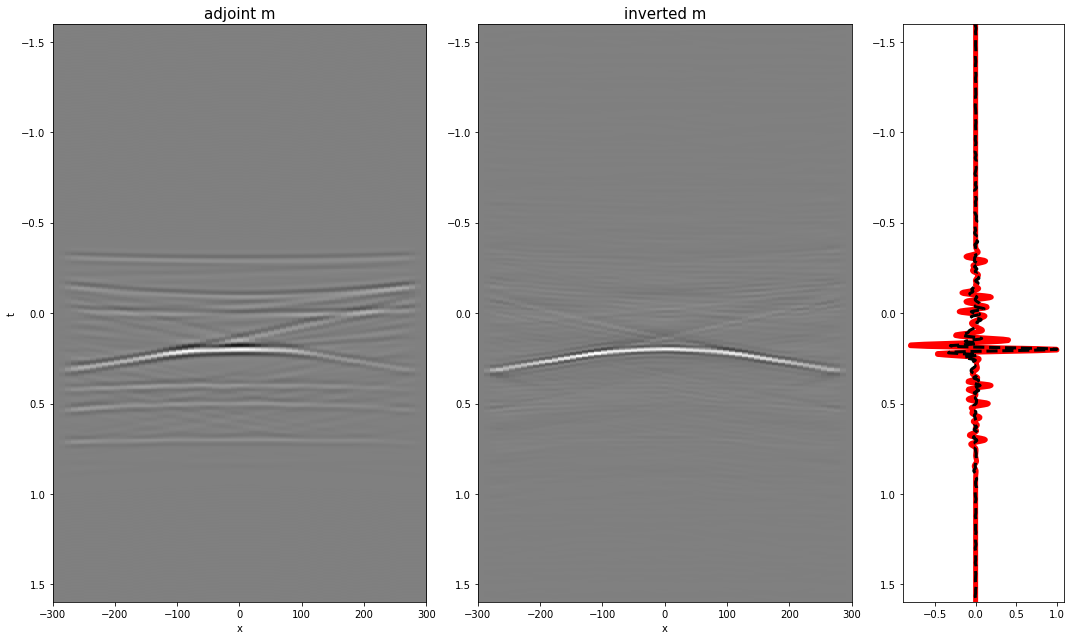

In [16]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(nr/2)]/np.abs(madj[:, int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(nr/2)]/np.abs(minv[:, int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We solve now the same problem with a preconditioning

$$\mathbf{d}= \mathbf{D} \mathbf{P} \mathbf{m}$$

where $\mathbf{P}$ is a masking operator that sets values in the negative part of the time axis equal to zero. This is added here as we know that our solution should be null in the negative time axis and it can be used to speed up convergence.

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    39950 rows  and    48739 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.980e+02  1.980e+02    1.0e+00  4.5e-01
     1  0.00000e+00   1.271e+02  1.271e+02    6.4e-01  6.7e-01   1.2e+02  1.0e+00
     2  0.00000e+00   9.132e+01  9.132e+01    4.6e-01  4.3e-01   1.7e+02  2.3e+00
     3  0.00000e+00   6.896e+01  6.896e+01    3.5e-01  3.0e-01   2.2e+02  3.9e+00
     4  0.00000e+00   5.466e+01  5.466e+01    2.8e-01  2.2e-01   2.6e+02  5.5e+00
     5  0.00000e+00   4.436e+01  4.436e+01    2.2e-01  1.9e-01   2.9e+02  7.2e+00
     6  0.00000e+00   3.723e+01  3.723e+01    1.9e-01  1.6e-01   3.1e+02  9.1e+00
     7  0.00000e+00   3.208e+01  3.208e+01    1.6e-01  1.4e-01   3.3e+02  1.1e+01
     8  0.00000e+00   2.827e

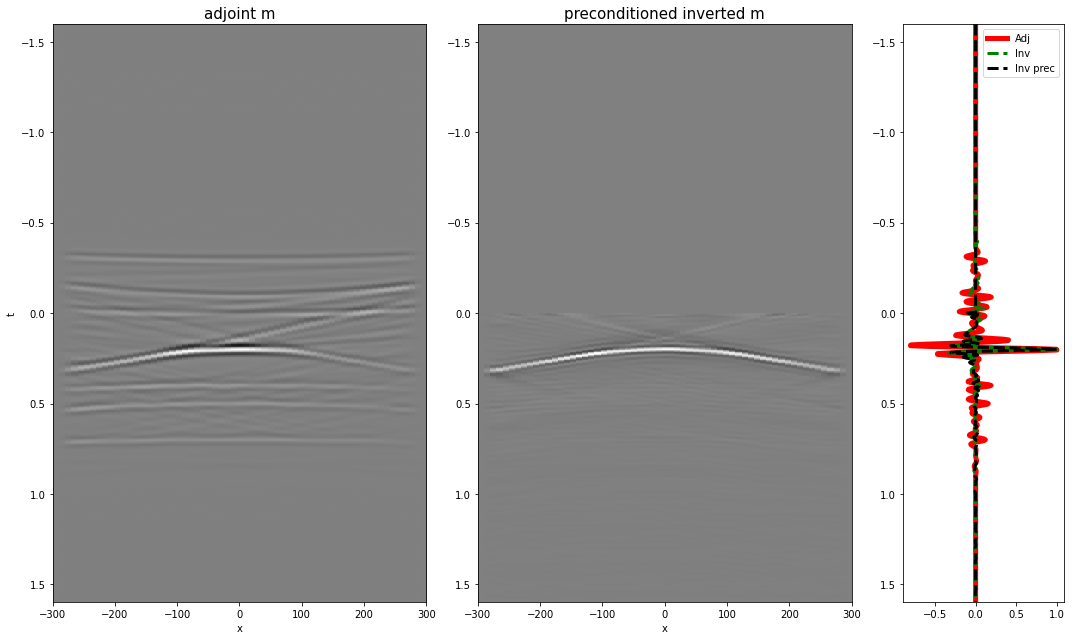

In [17]:
P = np.ones((nt*2-1, nr))
P[:nt-1]=0
Pop = Diagonal(P)

minv_prec= PreconditionedInversion(MDCop, Pop, d.ravel(), returninfo=True,
                                   **dict(damp=1e-10, iter_lim=10, show=1))[0]

minv_prec = minv_prec.reshape(2*par['nt']-1, par['nx'])


# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv_prec,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv_prec.max(), vmax=minv_prec.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('preconditioned inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(nr/2)]/np.abs(madj[:, int(nr/2)]).max(), t2, 'r', lw=5, label='Adj')
ax3.plot(minv[:, int(nr/2)]/np.abs(minv[:, int(nr/2)]).max(), t2, '--g', lw=3, label='Inv')
ax3.plot(minv_prec[:, int(nr/2)]/np.abs(minv_prec[:, int(nr/2)]).max(), t2, '--k', lw=3, label='Inv prec')
ax3.set_ylim([t2[-1],t2[0]])
ax3.legend()
fig.tight_layout()

Let's now take advantage of the high level MDD routine (which basically does what you have seen above...)

Dot test passed, v^T(Opu)=-1557.978450 - u^T(Op^Tv)=-1557.978450
Dot test passed, v^T(Opu)=3086.122079 - u^T(Op^Tv)=3086.122079
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    39950 rows  and    48739 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =        4
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.980e+02  1.980e+02    1.0e+00  5.0e-01
     1  0.00000e+00   1.292e+02  1.292e+02    6.5e-01  6.3e-01   1.3e+02  1.0e+00
     2  0.00000e+00   9.294e+01  9.294e+01    4.7e-01  3.9e-01   1.9e+02  2.3e+00
     3  0.00000e+00   7.188e+01  7.188e+01    3.6e-01  2.8e-01   2.4e+02  3.8e+00
     4  0.00000e+00   5.832e+01  5.832e+01    2.9e-01  2.2e-01   2.7e+02  5.5e+00
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 5.8e+01   anorm = 2.7e+02   arnorm = 3.6e+

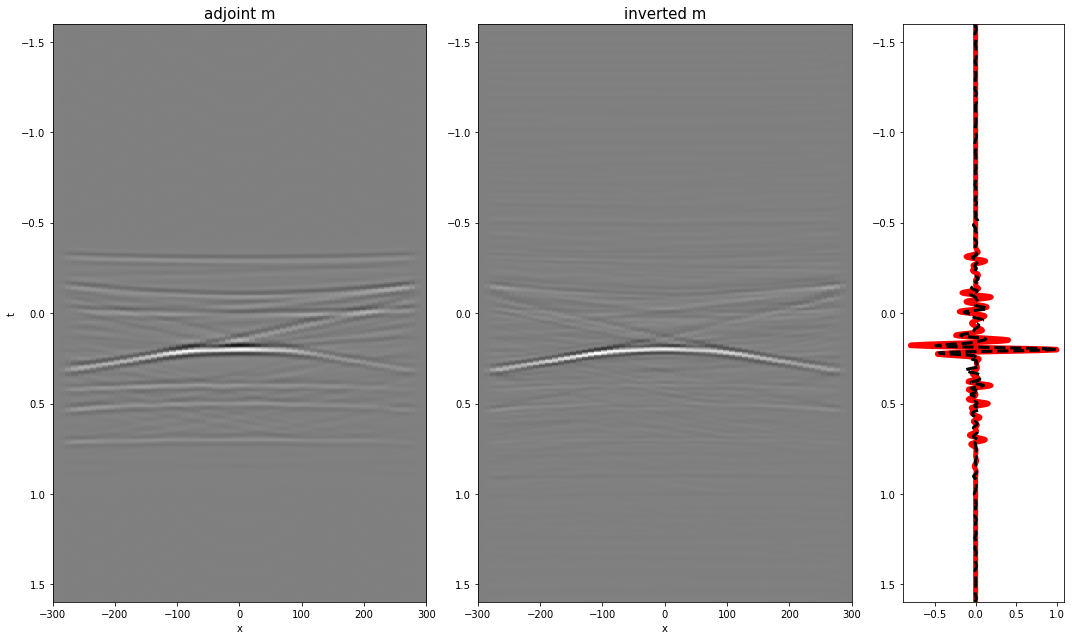

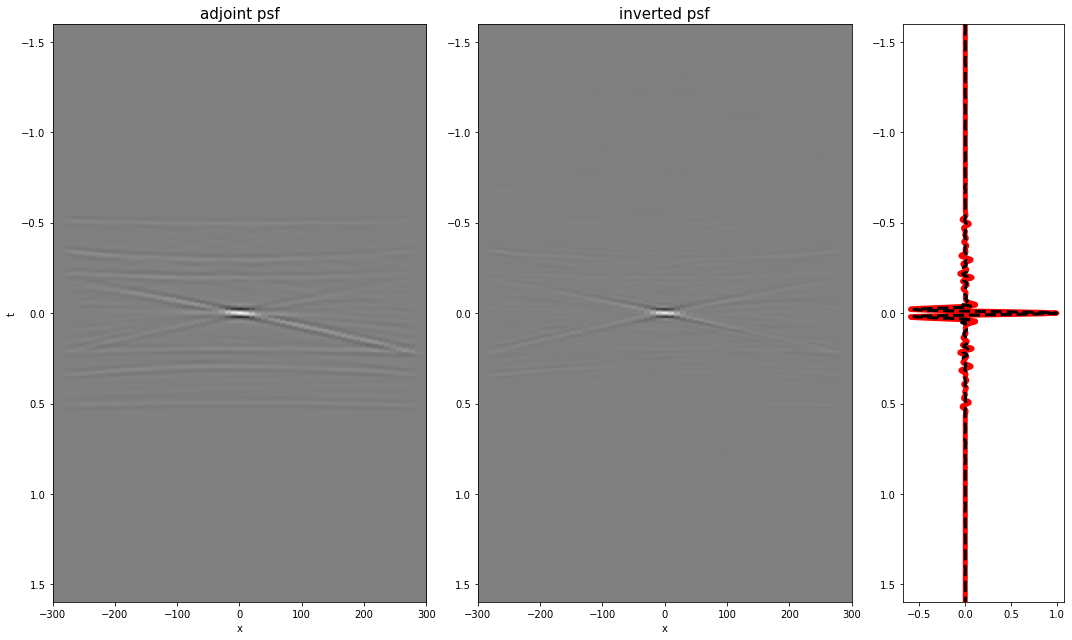

In [18]:
minv,madj,psfinv,psfadj = MDD(Gwav2, d.T, 
                              dt=dt, dr=dr, nfmax=799, twosided=True, 
                              add_negative=False,
                              adjoint=True, psf=True, dtype='complex64', dottest=True,
                              **dict(damp=1e-10, iter_lim=4, show=1))

# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(nr/2)]/np.abs(madj[int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(nr/2)]/np.abs(minv[int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(nr/2), int(nr/2)]/np.abs(psfadj[int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(nr/2), int(nr/2)]/np.abs(psfinv[int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

And same with preconditioner

Dot test passed, v^T(Opu)=-61.774756 - u^T(Op^Tv)=-61.774756
Dot test passed, v^T(Opu)=7896.722454 - u^T(Op^Tv)=7896.722454
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    39950 rows  and    48739 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.980e+02  1.980e+02    1.0e+00  4.5e-01
     1  0.00000e+00   1.271e+02  1.271e+02    6.4e-01  6.7e-01   1.2e+02  1.0e+00
     2  0.00000e+00   9.132e+01  9.132e+01    4.6e-01  4.3e-01   1.7e+02  2.3e+00
     3  0.00000e+00   6.896e+01  6.896e+01    3.5e-01  3.0e-01   2.2e+02  3.9e+00
     4  0.00000e+00   5.466e+01  5.466e+01    2.8e-01  2.2e-01   2.6e+02  5.5e+00
     5  0.00000e+00   4.436e+01  4.436e+01    2.2e-01  1.9e-01   2.9e+02  7.2e+00
     6  0.00000e+00   3.723e+01  3.723e+01    1.9e-01  1.6e-01   3.1

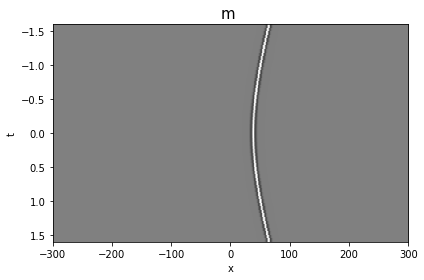

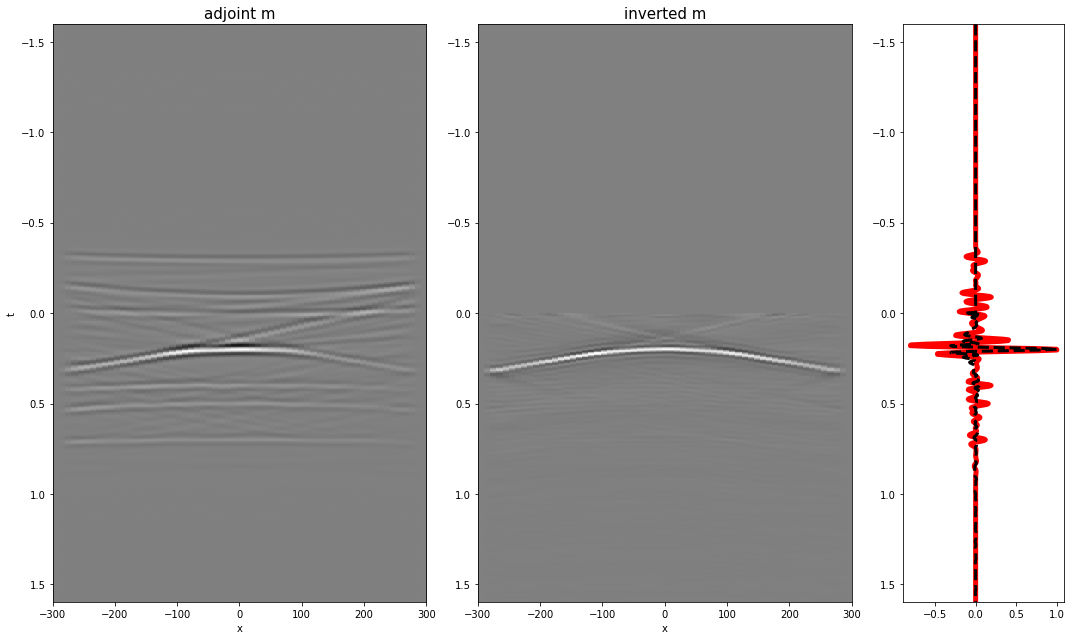

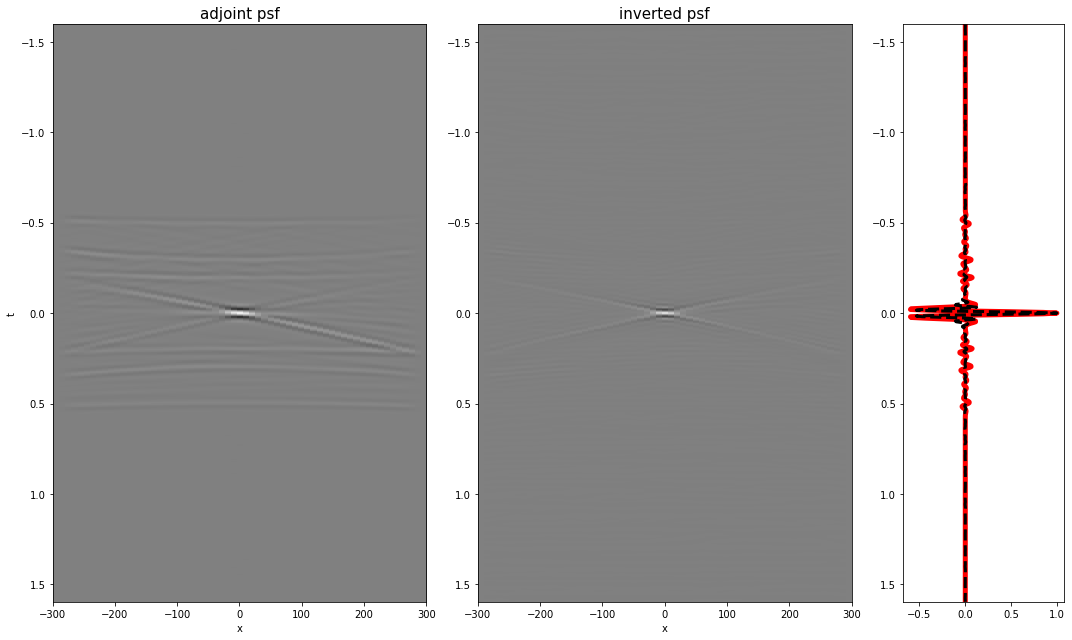

In [19]:
minv,madj,psfinv,psfadj = MDD(Gwav2, d.T, 
                              dt=dt, dr=dr, nfmax=799, twosided=True, 
                              add_negative=False, causality_precond=True, 
                              adjoint=True, psf=True, dtype='complex64', dottest=True,
                              **dict(damp=1e-10, iter_lim=10, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(nr/2)]/np.abs(madj[int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(nr/2)]/np.abs(minv[int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(nr/2), int(nr/2)]/np.abs(psfadj[int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(nr/2), int(nr/2)]/np.abs(psfinv[int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

### Multiple virtual sources

We consider now a case with multiple virtual sources

In [20]:
# Generate model
m, mwav =  hyperbolic3d(x,x,t,t0_m,vrms_m,vrms_m,amp_m,wav)
m, mwav = np.zeros((nr,nr,nt)), np.zeros((nr,nr,nt))
for ix,x0 in enumerate(x):
    m[ix],mwav[ix] = hyperbolic2d(x-x0,t,t0_m,vrms_m,amp_m,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((nr, nr, nt-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((nr, nr, nt-1)), mwav), axis=-1)

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*nt-1,
          nv=par['nx'], dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, (2*nt-1)*nr*ns,(2*nt-1)*nr*nr, verb=True)

# Create data
d = MDCop*m.transpose(2,0,1).flatten()
d = d.reshape(2*nt-1, ns, nr)

AssertionError: ignored

And we invert using the LSQR solver directly

In [ ]:
madj = MDCop.H*d.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.ravel(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*nt-1,nr, nr)
minv = minv.reshape(2*nt-1,nr, nr)

In [ ]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj[:, int(nr/2)], aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv[:, int(nr/2)], aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(nr/2), int(nr/2)]/np.abs(madj[:, int(nr/2), int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(nr/2), int(nr/2)]/np.abs(minv[:, int(nr/2), int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(nr/2), int(nr/2)]/np.abs(psfadj[int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(nr/2), int(nr/2)]/np.abs(psfinv[int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

Finally we use again the MDD routine

In [ ]:
# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav2, d.transpose(1, 2, 0), dt=dt, dr=dr, 
                              nfmax=nfmax, twosided=True, wav=wav,
                              adjoint=True, add_negative=False, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-10, iter_lim=10, show=1))

In [ ]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj[int(nr/2)].T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv[int(nr/2)].T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(nr/2), int(nr/2)]/np.abs(madj[int(nr/2), int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(nr/2), int(nr/2)]/np.abs(minv[int(nr/2), int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(nr/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(nr/2), int(nr/2)]/np.abs(psfadj[int(nr/2), int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(nr/2), int(nr/2)]/np.abs(psfinv[int(nr/2), int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()